# Лабораторная работа №5
## Цель работы: Изучить линейные модели, SVM и деревья решений<cite data-cite="ue:lab5"></cite>.

# Задание
Требуется выполнить следующие действия<cite data-cite="ue:lab5"></cite>:

1. Выбрать набор данных (датасет) для&nbsp;решения задачи классификации или регресии.
2. В&nbsp;случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С&nbsp;использованием метода `train_test_split` разделите выборку на&nbsp;обучающую и тестовую.
4. Обучите одну из&nbsp;линейных моделей, SVM и дерево решений. Оцените качество модели с&nbsp;помощью трех подходящих для&nbsp;задачи метрик. Сравните качество полученных моделей.
5. Произведите для&nbsp;каждой модели подбор одного гиперпараметра с&nbsp;использованием `GridSearchCV` и кросс-валидации.
6. Повторите пункт&nbsp;4 для&nbsp;найденных оптимальных значения гиперпараметров. Сравните качество полученных моделей с&nbsp;качеством моделей, полученных в&nbsp;пункте&nbsp;4.

Подключаем библиотеки: 

In [0]:
from google.colab import files
from datetime import datetime
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree

# Enable inline plots
%matplotlib inline

# Set plots formats to save high resolution PNG
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [3]:
#Загрузим датасет
uploaded = files.upload()

Saving datasets_418778_1048669_cbb20.csv to datasets_418778_1048669_cbb20.csv


## Предварительная подготовка данных

# Информация о датасете
В качестве датасета возьмем датасет с информацией о играх баскетбольных комманд колледжей.

Данные о содержании: (из источника, Kaggle)

RK (Only in cbb20): The ranking of the team at the end of the regular season according to barttorvik

TEAM: The Division I college basketball school

CONF: The Athletic Conference in which the school participates in (A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)

G: Number of games played

W: Number of games won

ADJOE: Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)

ADJDE: Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)

BARTHAG: Power Rating (Chance of beating an average Division I team)

EFG_O: Effective Field Goal Percentage Shot

EFG_D: Effective Field Goal Percentage Allowed

TOR: Turnover Percentage Allowed (Turnover Rate)

TORD: Turnover Percentage Committed (Steal Rate)

ORB: Offensive Rebound Percentage

DRB: Defensive Rebound Percentage

FTR : Free Throw Rate (How often the given team shoots Free Throws)

FTRD: Free Throw Rate Allowed

2P_O: Two-Point Shooting Percentage

2P_D: Two-Point Shooting Percentage Allowed

3P_O: Three-Point Shooting Percentage

3P_D: Three-Point Shooting Percentage Allowed

ADJ_T: Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)

WAB: Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)

POSTSEASON: Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)

SEED: Seed in the NCAA March Madness Tournament

YEAR: Season


In [0]:
data = pd.read_csv("datasets_418778_1048669_cbb20.csv")

Проверим типы данных в датасете:

In [6]:
data.dtypes

RK           int64
TEAM        object
CONF        object
G            int64
W            int64
ADJOE      float64
ADJDE      float64
BARTHAG    float64
EFG_O      float64
EFG_D      float64
TOR        float64
TORD       float64
ORB        float64
DRB        float64
FTR        float64
FTRD       float64
2P_O       float64
2P_D       float64
3P_O       float64
3P_D       float64
ADJ_T      float64
WAB        float64
dtype: object

Посмотриа как это выглядит:

In [7]:
data.head()

,RK,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
0,1,Kansas,B12,30,28,116.1,87.7,0.9616,53.7,43.7,18.7,18.6,32.6,26.4,35.8,23.2,54.9,42.4,34.1,30.5,67.4,10.8
1,2,Baylor,B12,30,26,114.5,88.4,0.9513,49.4,45.2,17.8,22.7,35.8,29.8,30.8,30.8,47.5,44.4,35.1,31.1,66.2,8.5
2,3,Gonzaga,WCC,33,31,121.3,94.3,0.9472,57.5,47.6,15.3,18.4,33.6,22.7,38.8,21.8,57.4,47.4,38.6,32.0,72.0,7.7
3,4,Dayton,A10,31,29,119.5,93.4,0.9445,59.7,46.6,18.0,18.8,26.4,26.6,33.9,30.9,62.3,45.1,37.1,33.0,67.5,6.8
4,5,Michigan St.,B10,31,22,114.8,91.3,0.9326,52.6,43.3,18.1,15.8,32.8,26.0,30.8,29.3,52.9,43.4,34.8,28.7,69.3,5.2


Нам не очень интересны столбцы TEAM и CONF, так что избавимся от них

In [0]:
data.drop(['TEAM', 'CONF'],axis='columns', inplace=True)

In [11]:
data.dtypes

RK           int64
G            int64
W            int64
ADJOE      float64
ADJDE      float64
BARTHAG    float64
EFG_O      float64
EFG_D      float64
TOR        float64
TORD       float64
ORB        float64
DRB        float64
FTR        float64
FTRD       float64
2P_O       float64
2P_D       float64
3P_O       float64
3P_D       float64
ADJ_T      float64
WAB        float64
dtype: object

С оставшимеся данными можем работать. Посмотримразмер датасета:

In [13]:
data.shape

(353, 20)

Проверим основные статистические характеристики набора данных:

In [14]:
data.describe()

,RK,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
count,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000,353.000000
mean,177.000000,30.186969,16.305949,102.241926,102.241926,0.497690,49.568555,49.606232,18.920397,18.897450,27.887819,27.967989,32.643626,32.792351,49.429745,49.426346,33.188102,33.266572,68.296601,-7.701416
std,102.046558,1.607564,5.484212,6.775256,6.430723,0.250529,2.793632,2.779841,2.020979,2.257429,3.996233,2.939827,4.872543,5.940799,3.078868,3.193862,2.575932,2.390990,2.642956,6.763289
min,1.000000,24.000000,1.000000,80.100000,85.600000,0.019400,39.300000,41.200000,13.600000,14.000000,14.200000,19.000000,21.700000,19.700000,40.200000,40.700000,24.800000,27.200000,59.400000,-25.200000
25%,89.000000,29.000000,13.000000,97.300000,98.000000,0.281800,47.600000,47.600000,17.800000,17.400000,25.200000,26.000000,29.100000,28.900000,47.300000,47.400000,31.500000,31.600000,66.400000,-12.800000
50%,177.000000,30.000000,16.000000,102.200000,102.000000,0.480400,49.600000,49.500000,18.800000,18.700000,27.900000,28.000000,32.600000,31.900000,49.400000,49.400000,33.300000,33.200000,68.200000,-7.600000
75%,265.000000,31.000000,20.000000,106.700000,106.400000,0.720700,51.500000,51.500000,20.300000,20.300000,30.600000,29.900000,35.800000,36.300000,51.500000,51.600000,34.900000,34.700000,69.800000,-3.100000
max,353.000000,34.000000,31.000000,121.300000,122.700000,0.961600,59.700000,58.400000,26.600000,27.800000,40.100000,36.900000,48.100000,53.000000,62.300000,58.400000,41.900000,40.600000,77.400000,10.800000


Проверим наличие пропусков в&nbsp;данных:

In [15]:
data.isnull().sum()

RK         0
G          0
W          0
ADJOE      0
ADJDE      0
BARTHAG    0
EFG_O      0
EFG_D      0
TOR        0
TORD       0
ORB        0
DRB        0
FTR        0
FTRD       0
2P_O       0
2P_D       0
3P_O       0
3P_D       0
ADJ_T      0
WAB        0
dtype: int64

## Разделение данных
Разделим данные на&nbsp;целевой столбец и признаки:

In [0]:
y = data["RK"]
X = data.drop("RK", axis=1)

In [17]:
print(X.head(), "\n")
print(y.head())

    G   W  ADJOE  ADJDE  BARTHAG  EFG_O  ...  2P_O  2P_D  3P_O  3P_D  ADJ_T   WAB
0  30  28  116.1   87.7   0.9616   53.7  ...  54.9  42.4  34.1  30.5   67.4  10.8
1  30  26  114.5   88.4   0.9513   49.4  ...  47.5  44.4  35.1  31.1   66.2   8.5
2  33  31  121.3   94.3   0.9472   57.5  ...  57.4  47.4  38.6  32.0   72.0   7.7
3  31  29  119.5   93.4   0.9445   59.7  ...  62.3  45.1  37.1  33.0   67.5   6.8
4  31  22  114.8   91.3   0.9326   52.6  ...  52.9  43.4  34.8  28.7   69.3   5.2

[5 rows x 19 columns] 

0    1
1    2
2    3
3    4
4    5
Name: RK, dtype: int64


In [18]:
print(X.shape)
print(y.shape)

(353, 19)
(353,)


Предобработаем данные, чтобы методы работали лучше:

In [19]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
count,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02,3.530000e+02
mean,5.346683e-16,1.002660e-15,-1.090723e-15,3.073399e-15,-6.856335e-17,2.175786e-15,2.402862e-16,-5.095075e-16,-2.453184e-16,3.057045e-16,-7.485356e-16,-1.086320e-15,1.993998e-16,2.843177e-15,-8.605015e-16,9.837897e-16,4.403151e-17,5.494975e-15,2.195285e-16
std,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00,1.001419e+00
min,-3.854124e+00,-2.794873e+00,-3.272697e+00,-2.591551e+00,-1.911827e+00,-3.680919e+00,-3.028290e+00,-2.636321e+00,-2.172561e+00,-3.430042e+00,-3.054846e+00,-2.249167e+00,-2.206931e+00,-3.002028e+00,-2.736102e+00,-3.260959e+00,-2.540865e+00,-3.370934e+00,-2.590962e+00
25%,-7.394130e-01,-6.036677e-01,-7.304435e-01,-6.605707e-01,-8.629571e-01,-7.056584e-01,-7.227319e-01,-5.551701e-01,-6.642848e-01,-6.735428e-01,-6.703736e-01,-7.282966e-01,-6.561199e-01,-6.927119e-01,-6.353506e-01,-6.562666e-01,-6.980112e-01,-7.186244e-01,-7.549317e-01
50%,-1.164708e-01,-5.586642e-02,-6.196941e-03,-3.767379e-02,-6.910995e-02,1.127185e-02,-3.826948e-02,-5.965797e-02,-8.759108e-02,3.052523e-03,1.090431e-02,-8.966158e-03,-1.504205e-01,-9.674747e-03,-8.260535e-03,4.350148e-02,-2.788248e-02,-3.660208e-02,1.501642e-02
75%,5.064715e-01,6.745353e-01,6.589274e-01,6.475128e-01,8.914212e-01,6.923555e-01,6.822173e-01,6.836102e-01,6.221857e-01,6.796478e-01,6.581183e-01,6.487074e-01,5.912719e-01,6.733624e-01,6.815385e-01,6.655175e-01,6.003632e-01,5.696400e-01,6.813177e-01
max,2.375298e+00,2.683140e+00,2.816886e+00,3.185818e+00,1.854351e+00,3.631769e+00,3.167897e+00,3.805336e+00,3.949265e+00,3.060261e+00,3.042591e+00,3.176640e+00,3.406332e+00,4.186125e+00,2.813645e+00,3.386838e+00,3.071463e+00,3.449290e+00,2.739448e+00


Разделим выборку на&nbsp;тренировочную и тестовую:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=346705925)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(264, 19)
(89, 19)
(264,)
(89,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [0]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

### Линейная модель — Lasso

Запустим метод Lasso с&nbsp;гиперпараметром $\alpha=1$:

In [23]:
las_1 = Lasso(alpha=1.0)
las_1.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Проверим метрики построенной модели:

In [24]:
test_model(las_1)

mean_absolute_error: 5.132358994321031
median_absolute_error: 4.602639306430007
r2_score: 0.9961588783795767


### SVM

Запустим метод NuSVR с&nbsp;гиперпараметром $\nu=0{,}5$:

In [25]:
nusvr_05 = NuSVR(nu=0.5, gamma='scale')
nusvr_05.fit(X_train, y_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

Проверим метрики построенной модели:

In [26]:
test_model(nusvr_05)

mean_absolute_error: 79.04622918890769
median_absolute_error: 77.80523807923385
r2_score: 0.21886636832668083


SVM выдал гораздо более плохие результаты, чем Lasso.

### Дерево решений

Попробуем дерево решений с&nbsp;неограниченной глубиной дерева:

In [27]:
dt_none = DecisionTreeRegressor(max_depth=None)
dt_none.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Проверим метрики построенной модели:

In [28]:
test_model(dt_none)

mean_absolute_error: 2.5280898876404496
median_absolute_error: 2.0
r2_score: 0.9991512168865807


Древо решений показало результат в 2 раза лучше чем Lasso, и гораздо лучше чем SVM:

In [0]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов:", n_nodes)
    print("Листовых узлов:", sum(is_leaves))
    print("Глубина дерева:", max(node_depth))
    print("Минимальная глубина листьев дерева:", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева:", node_depth[is_leaves].mean())

In [30]:
stat_tree(dt_none)

Всего узлов: 527
Листовых узлов: 264
Глубина дерева: 9
Минимальная глубина листьев дерева: 7
Средняя глубина листьев дерева: 8.159090909090908


## Подбор гиперпараметра $K$

### Линейная модель — Lasso

Введем список настраиваемых параметров:

In [31]:
param_range = np.arange(0.001, 2.01, 0.1)
tuned_parameters = [{'alpha': param_range}]
tuned_parameters

[{'alpha': array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
         6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
         1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
         1.801e+00, 1.901e+00, 2.001e+00])}]

Запустим подбор параметра:

In [32]:
gs = GridSearchCV(Lasso(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

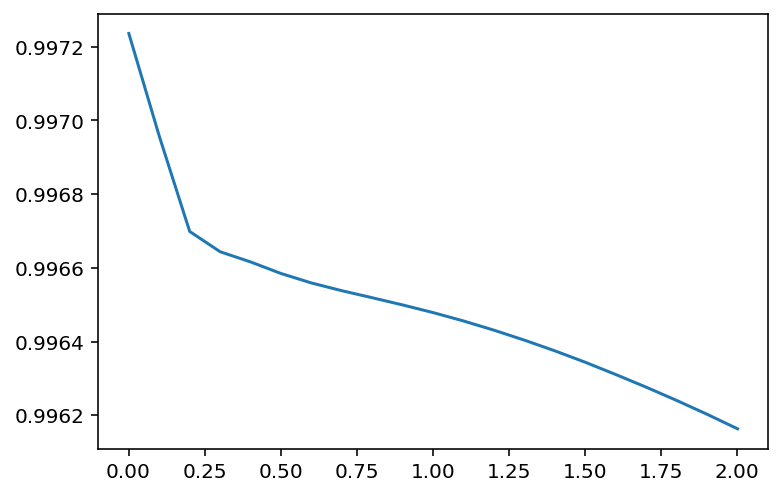

In [33]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что метод Lasso здесь не особо хорошо справляется, и выдает странный график.

На&nbsp;тестовом наборе данных картина ровно та же:

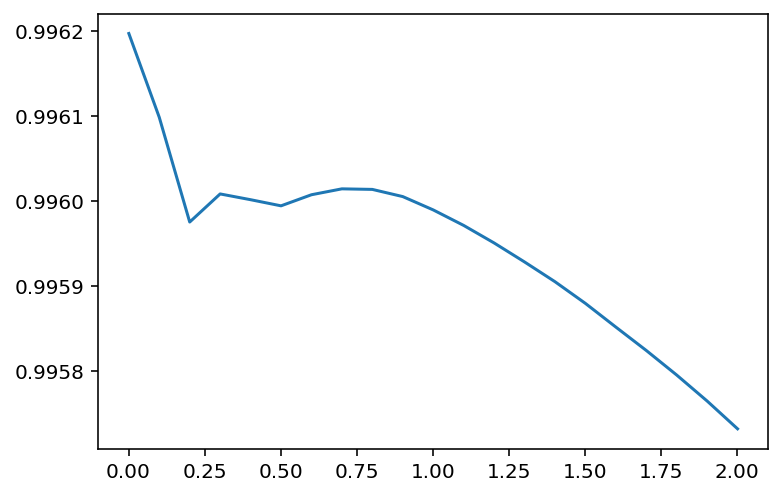

In [34]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Будем считать, что GridSearch показал, что нам нужна обычная линейная регрессия:

In [35]:
reg = LinearRegression()
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 4.761368518630553
median_absolute_error: 4.383129395277479
r2_score: 0.996808999860798


Получили немного лучший результат, однако очевидно,что данный метод не&nbsp;может дать хороший результат для&nbsp;данной выборки.

### SVM

Введем список настраиваемых параметров:

In [36]:
param_range = np.arange(0.1, 1.01, 0.1)
tuned_parameters = [{'nu': param_range}]
tuned_parameters

[{'nu': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}]

Запустим подбор параметра:

In [37]:
gs = GridSearchCV(NuSVR(gamma='scale'), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.9, shrinking=True, tol=0.001, verbose=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

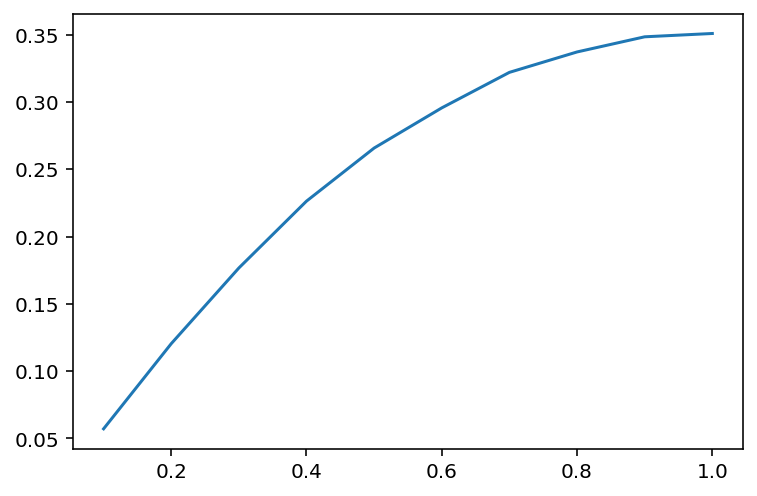

In [38]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что метод NuSVR справляется лучше, но не глобально.

На&nbsp;тестовом наборе данных картина ровно та же:

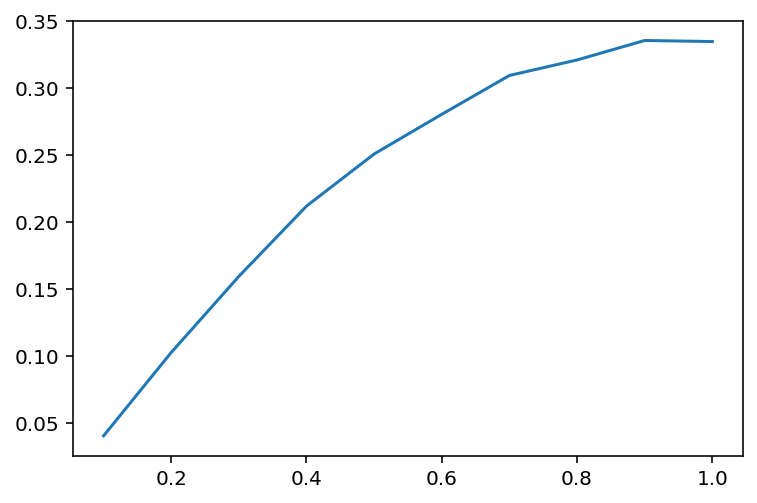

In [39]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Проведем обучение заново с параметром 0,3

In [53]:
nusvr_05 = NuSVR(nu=0.3, gamma='scale')
nusvr_05.fit(X_train, y_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.3, shrinking=True, tol=0.001, verbose=False)

In [55]:
test_model(nusvr_05)

mean_absolute_error: 82.97476834511633
median_absolute_error: 87.70985240826414
r2_score: 0.1449776491586927


К сожалению, результаты снова ухудшились

### Дерево решений

Введем список настраиваемых параметров:

In [40]:
param_range = np.arange(1, 51, 2)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
         35, 37, 39, 41, 43, 45, 47, 49])}]

Запустим подбор параметра:

In [41]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=39,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

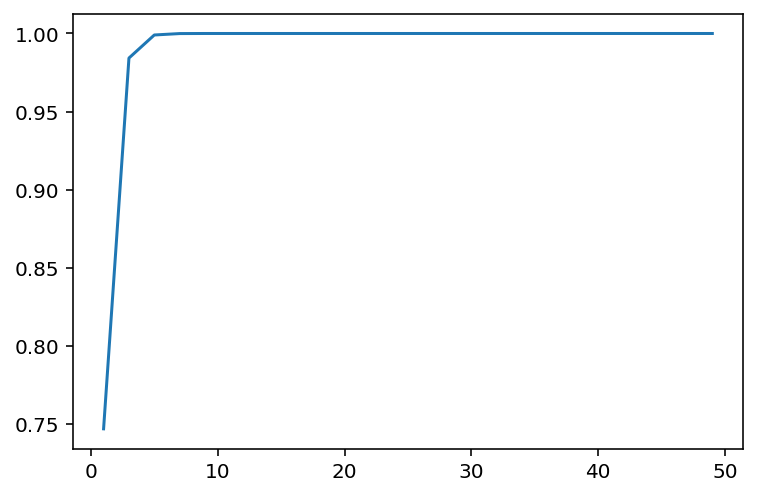

In [42]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что на&nbsp;тестовой выборке модель легко переобучается.

На&nbsp;тестовом наборе данных картина аналогична:

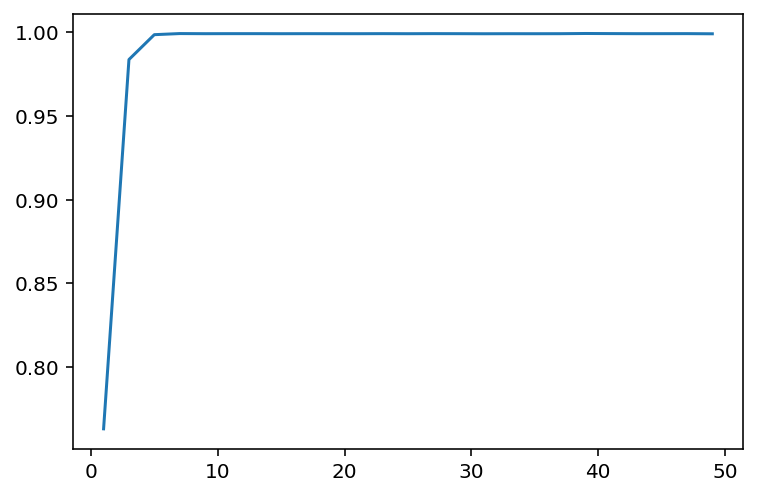

In [43]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Проведем дополнительное исследование в&nbsp;районе пика.

In [44]:
param_range = np.arange(7, 14, 1)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 7,  8,  9, 10, 11, 12, 13])}]

In [45]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

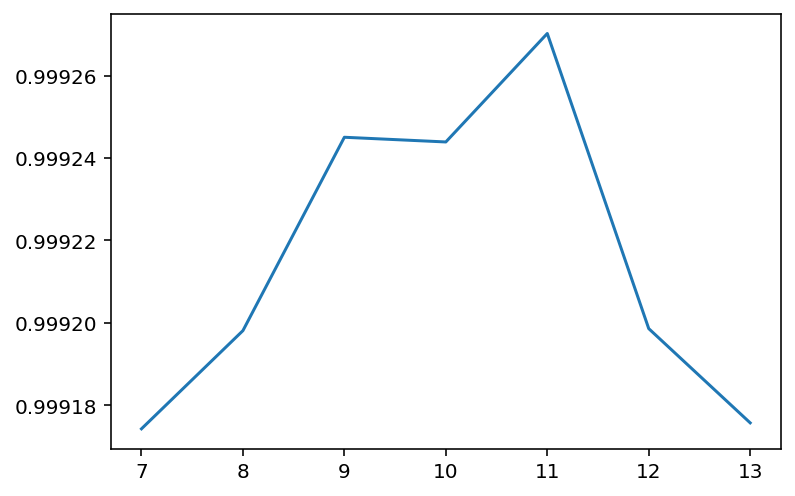

In [46]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Получили, что глубину дерева необходимо ограничить 11&nbsp;уровнями. Проверим этот результат.

In [57]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 2.7865168539325844
median_absolute_error: 2.0
r2_score: 0.9989853135037561


Вновь посмотрим статистику получившегося дерева решений.

In [48]:
stat_tree(reg)

Всего узлов: 527
Листовых узлов: 264
Глубина дерева: 9
Минимальная глубина листьев дерева: 7
Средняя глубина листьев дерева: 8.159090909090908


В&nbsp;целом получили примерно тот же результат. 
Посмотрим на&nbsp;построенное дерево.

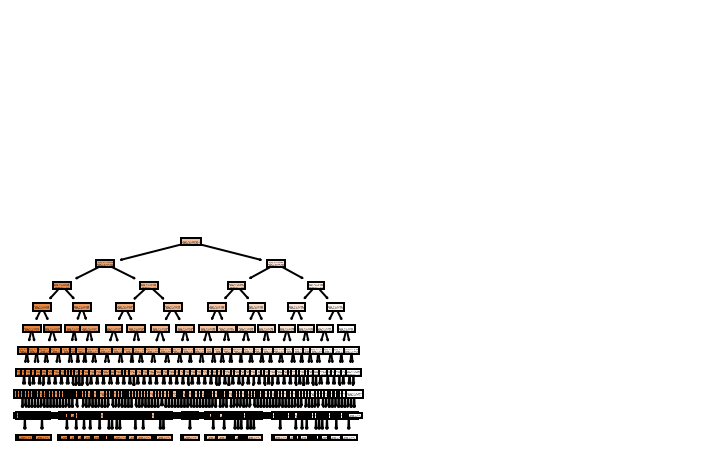

In [49]:
plot_tree(reg, filled=True);

Вывод функции `plot_tree` выглядит весьма странно. Видимо, для&nbsp;настолько больших деревьев решений она не&nbsp;предназначена. 

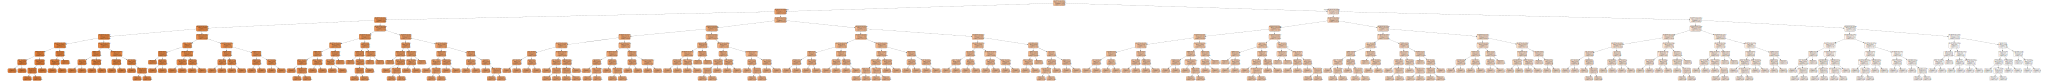

In [50]:
dot_data = export_graphviz(reg, out_file=None, feature_names=columns,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

Данное дерево уже выглядит более наглядно. Заметно что было сгенерировано множество условий, и, можно сказать, чир модель была переобучена, с другой стороны, для задачи регресии древо и не могло быть построено иначе. Несмотря на то что на тестовой выборке древо показало свою работоспособность, лучше использовать данный метод для задач классификации.